In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files 
%matplotlib inline

In [ ]:
%cd "/content/drive/MyDrive/CS354_minorProject/Brain_MRI/"

/content/drive/MyDrive/CS354_minorProject/Brain_MRI


In [ ]:
brain_df=pd.read_csv("data_mask.csv")

## Data Visualization

In [ ]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [ ]:
brain_df

patient_id  ... mask
0     TCGA_CS_5395_19981004  ...    0
1     TCGA_CS_5395_19981004  ...    0
2     TCGA_CS_5395_19981004  ...    0
3     TCGA_CS_5395_19981004  ...    0
4     TCGA_CS_5395_19981004  ...    0
...                     ...  ...  ...
3924  TCGA_DU_6401_19831001  ...    0
3925  TCGA_DU_6401_19831001  ...    0
3926  TCGA_DU_6401_19831001  ...    0
3927  TCGA_DU_6401_19831001  ...    0
3928  TCGA_DU_6401_19831001  ...    0

[3929 rows x 4 columns]

In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

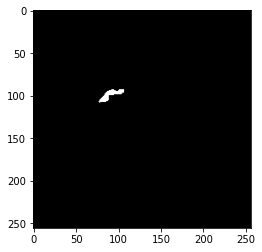

In [ ]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

In [ ]:
print("Max "+ str(cv2.imread(brain_df.mask_path[623]).max()))
print("Min "+str(cv2.imread(brain_df.mask_path[623]).min()))

Max 255
Min 0


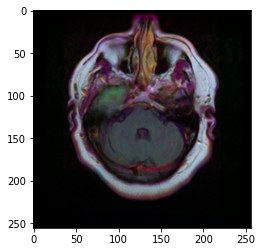

In [ ]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

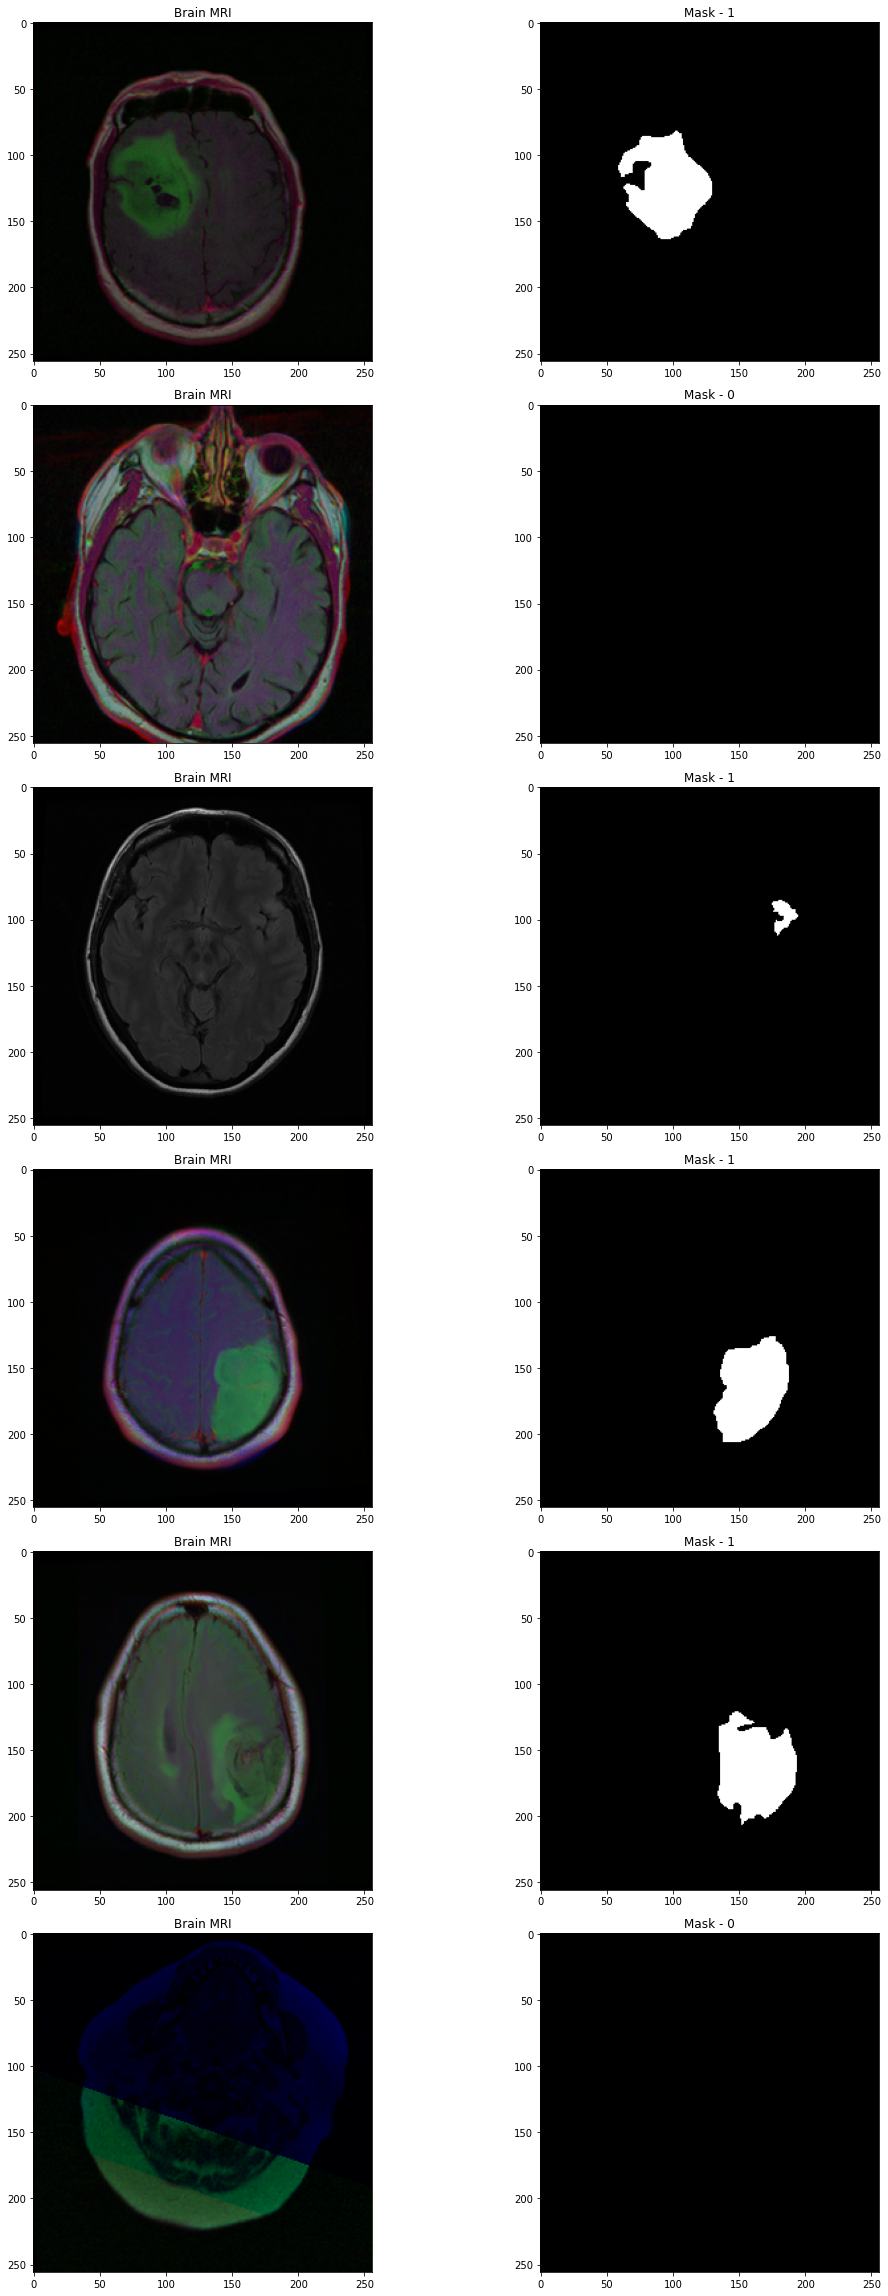

In [ ]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

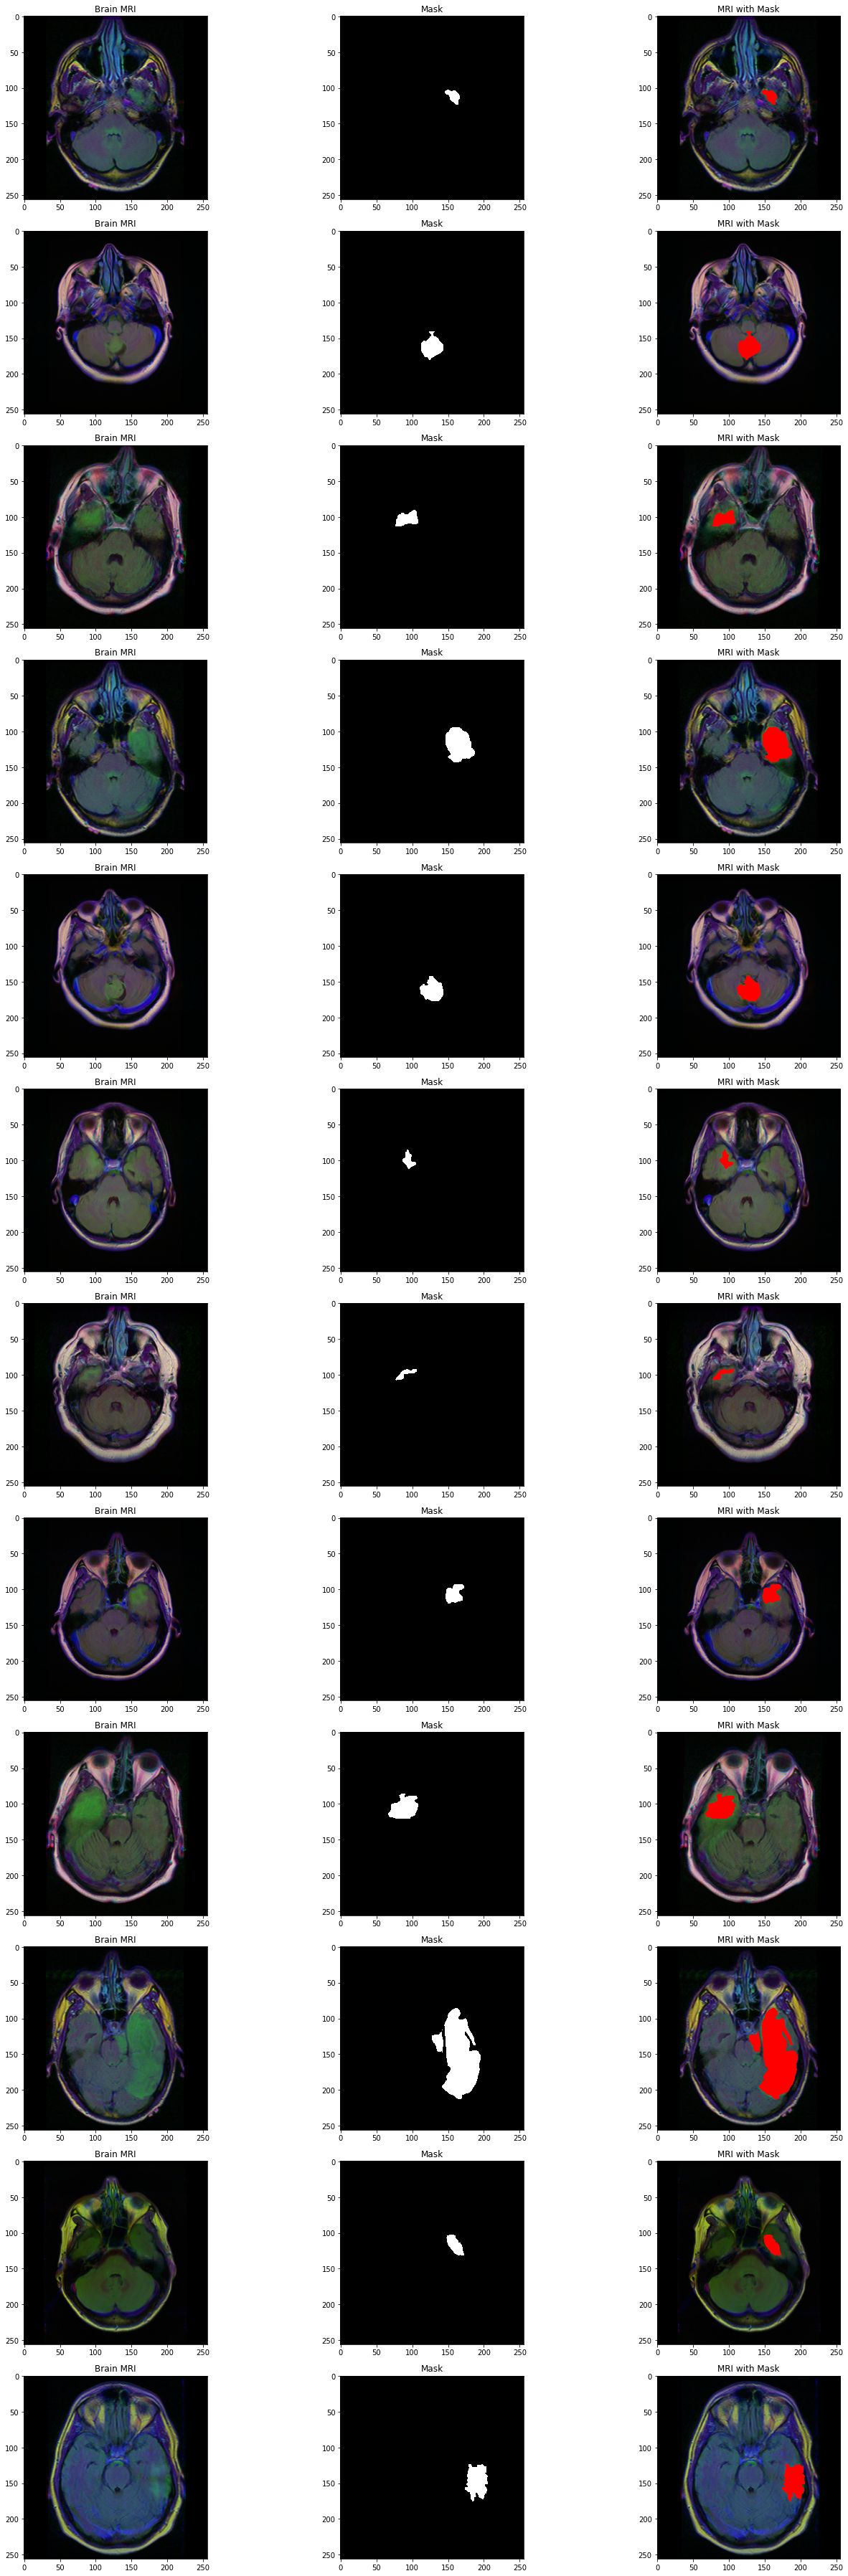

In [ ]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

## CLASSIFIER MODEL

## RESNET

In [ ]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [ ]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


## Transfer Learning

In [ ]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# freeze the model weights
for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
# Add classification head to the base model
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# compile the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="resnet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 15, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/15
177/177 [==============================] - 910s 5s/step - loss: 0.7094 - accuracy: 0.7166 - val_loss: 1.0055 - val_accuracy: 0.3609

Epoch 00001: val_loss improved from inf to 1.00551, saving model to resnet-weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
177/177 [==============================] - 84s 477ms/step - loss: 0.4319 - accuracy: 0.8176 - val_loss: 0.8748 - val_accuracy: 0.6411

Epoch 00002: val_loss improved from 1.00551 to 0.87477, saving model to resnet-weights.hdf5
Epoch 3/15
177/177 [==============================] - 85s 478ms/step - loss: 0.3959 - accuracy: 0.8424 - val_loss: 1.0874 - val_accuracy: 0.6411

Epoch 00003: val_loss did not improve from 0.87477
Epoch 4/15
177/177 [==============================] - 84s 477ms/step - loss: 0.3278 - accuracy: 0.8679 - val_loss: 0.8787 - val_accuracy: 0.6431

Epoch 00004: val_loss did not improve from 0.87477
Epoch 5/15
177/177 [==============================] - 85s 479ms/step - loss: 0.2754 - accuracy: 0.9033 - val_loss: 0.4554 - val_accuracy: 0.8004

Epoch 00005: val_loss improved from 0.87477 to 0.45544, saving model to resnet-weights.hdf5
Epoch 6/15
177/177 [==============================] - 85s 478ms/step - loss: 0.2209 - accuracy: 0.9182 - val_loss: 0.3067 - val_ac

In [ ]:
# save the model architecture to json file for future use
model_json = model.to_json()
with open("resnet-model.json","w") as json_file:
  json_file.write(model_json)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## ASSESSING RESNET MODEL PERFORMANCE

In [ ]:
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# make prediction
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 159s 5s/step


In [ ]:
test_predict.shape

(576, 2)

In [ ]:
test_predict

array([[9.6989048e-01, 3.0109519e-02],
       [1.0000000e+00, 1.8711062e-11],
       [1.0000000e+00, 2.4522425e-08],
       ...,
       [9.9999285e-01, 7.1428199e-06],
       [9.9999940e-01, 5.9308087e-07],
       [9.9992800e-01, 7.1986600e-05]], dtype=float32)

In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)
predict

array(['0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '1', '0', '0',
       '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0',
       '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0',
       '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '1', '1', '0',
       '1', '0', '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0',
       '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '1',
       '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0',
       '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0',
       '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0',
       '0', '0', '1', '0', '1', '0', '1', '1', '1', '0', '0', '0', '0',
       '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1',
       '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0

In [ ]:
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(original, predict)
accuracy

0.9826388888888888

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       379
           1       0.97      0.97      0.97       197

   micro avg       0.98      0.98      0.98       576
   macro avg       0.98      0.98      0.98       576
weighted avg       0.98      0.98      0.98       576



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


# Image Segmentation

## RESUNET MODEL

**Localize** **Tumor**

In [ ]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [ ]:
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [ ]:
from utilities import DataGenerator

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [ ]:
def resblock(X, f):
  

  X_copy = X

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [ ]:
from utilities import  tversky_loss, tversky

In [ ]:
def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
model_seg.fit(training_generator, epochs = 15, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

Epoch 1/15
72/72 [==============================] - 329s 4s/step - loss: 0.7748 - tversky: 0.2851 - val_loss: 0.9431 - val_tversky: 0.0750

Epoch 00001: val_loss improved from inf to 0.94313, saving model to ResUNet-weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
72/72 [==============================] - 30s 409ms/step - loss: 0.4362 - tversky: 0.6667 - val_loss: 0.5678 - val_tversky: 0.5287

Epoch 00002: val_loss improved from 0.94313 to 0.56777, saving model to ResUNet-weights.hdf5
Epoch 3/15
72/72 [==============================] - 27s 379ms/step - loss: 0.3640 - tversky: 0.7380 - val_loss: 0.4389 - val_tversky: 0.6648

Epoch 00003: val_loss improved from 0.56777 to 0.43890, saving model to ResUNet-weights.hdf5
Epoch 4/15
72/72 [==============================] - 27s 374ms/step - loss: 0.3166 - tversky: 0.7823 - val_loss: 0.4284 - val_tversky: 0.6752

Epoch 00004: val_loss improved from 0.43890 to 0.42842, saving model to ResUNet-weights.hdf5
Epoch 5/15
72/72 [==============================] - 27s 374ms/step - loss: 0.2780 - tversky: 0.8166 - val_loss: 0.2982 - val_tversky: 0.8004

Epoch 00005: val_loss improved from 0.42842 to 0.29823, saving model to ResUNet-weights.hdf5
Epoch 6/15
72/72 [==============================] - 27s 374m

## Assessing RESUNET Model Performance

In [ ]:
with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from utilities import prediction

image_id, mask, has_mask = prediction(test, model, model_seg)

In [ ]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  ... has_mask
0    TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_6.tif  ...        0
1    TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_2.tif  ...        0
2    TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_20...  ...        0
3    TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_23...  ...        1
4    TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_80...  ...        0
..                                                 ...  ...      ...
585  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_77...  ...        0
586  TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_26...  ...        1
587  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_69...  ...        0
588  TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_6.tif  ...        0
589  TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_3.tif  ...        0

[590 rows x 3 columns]

In [ ]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  ... has_mask
0  TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_6.tif  ...        0
1  TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_2.tif  ...        0
2  TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_20...  ...        0
3  TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_23...  ...        1
4  TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_80...  ...        0

[5 rows x 5 columns]

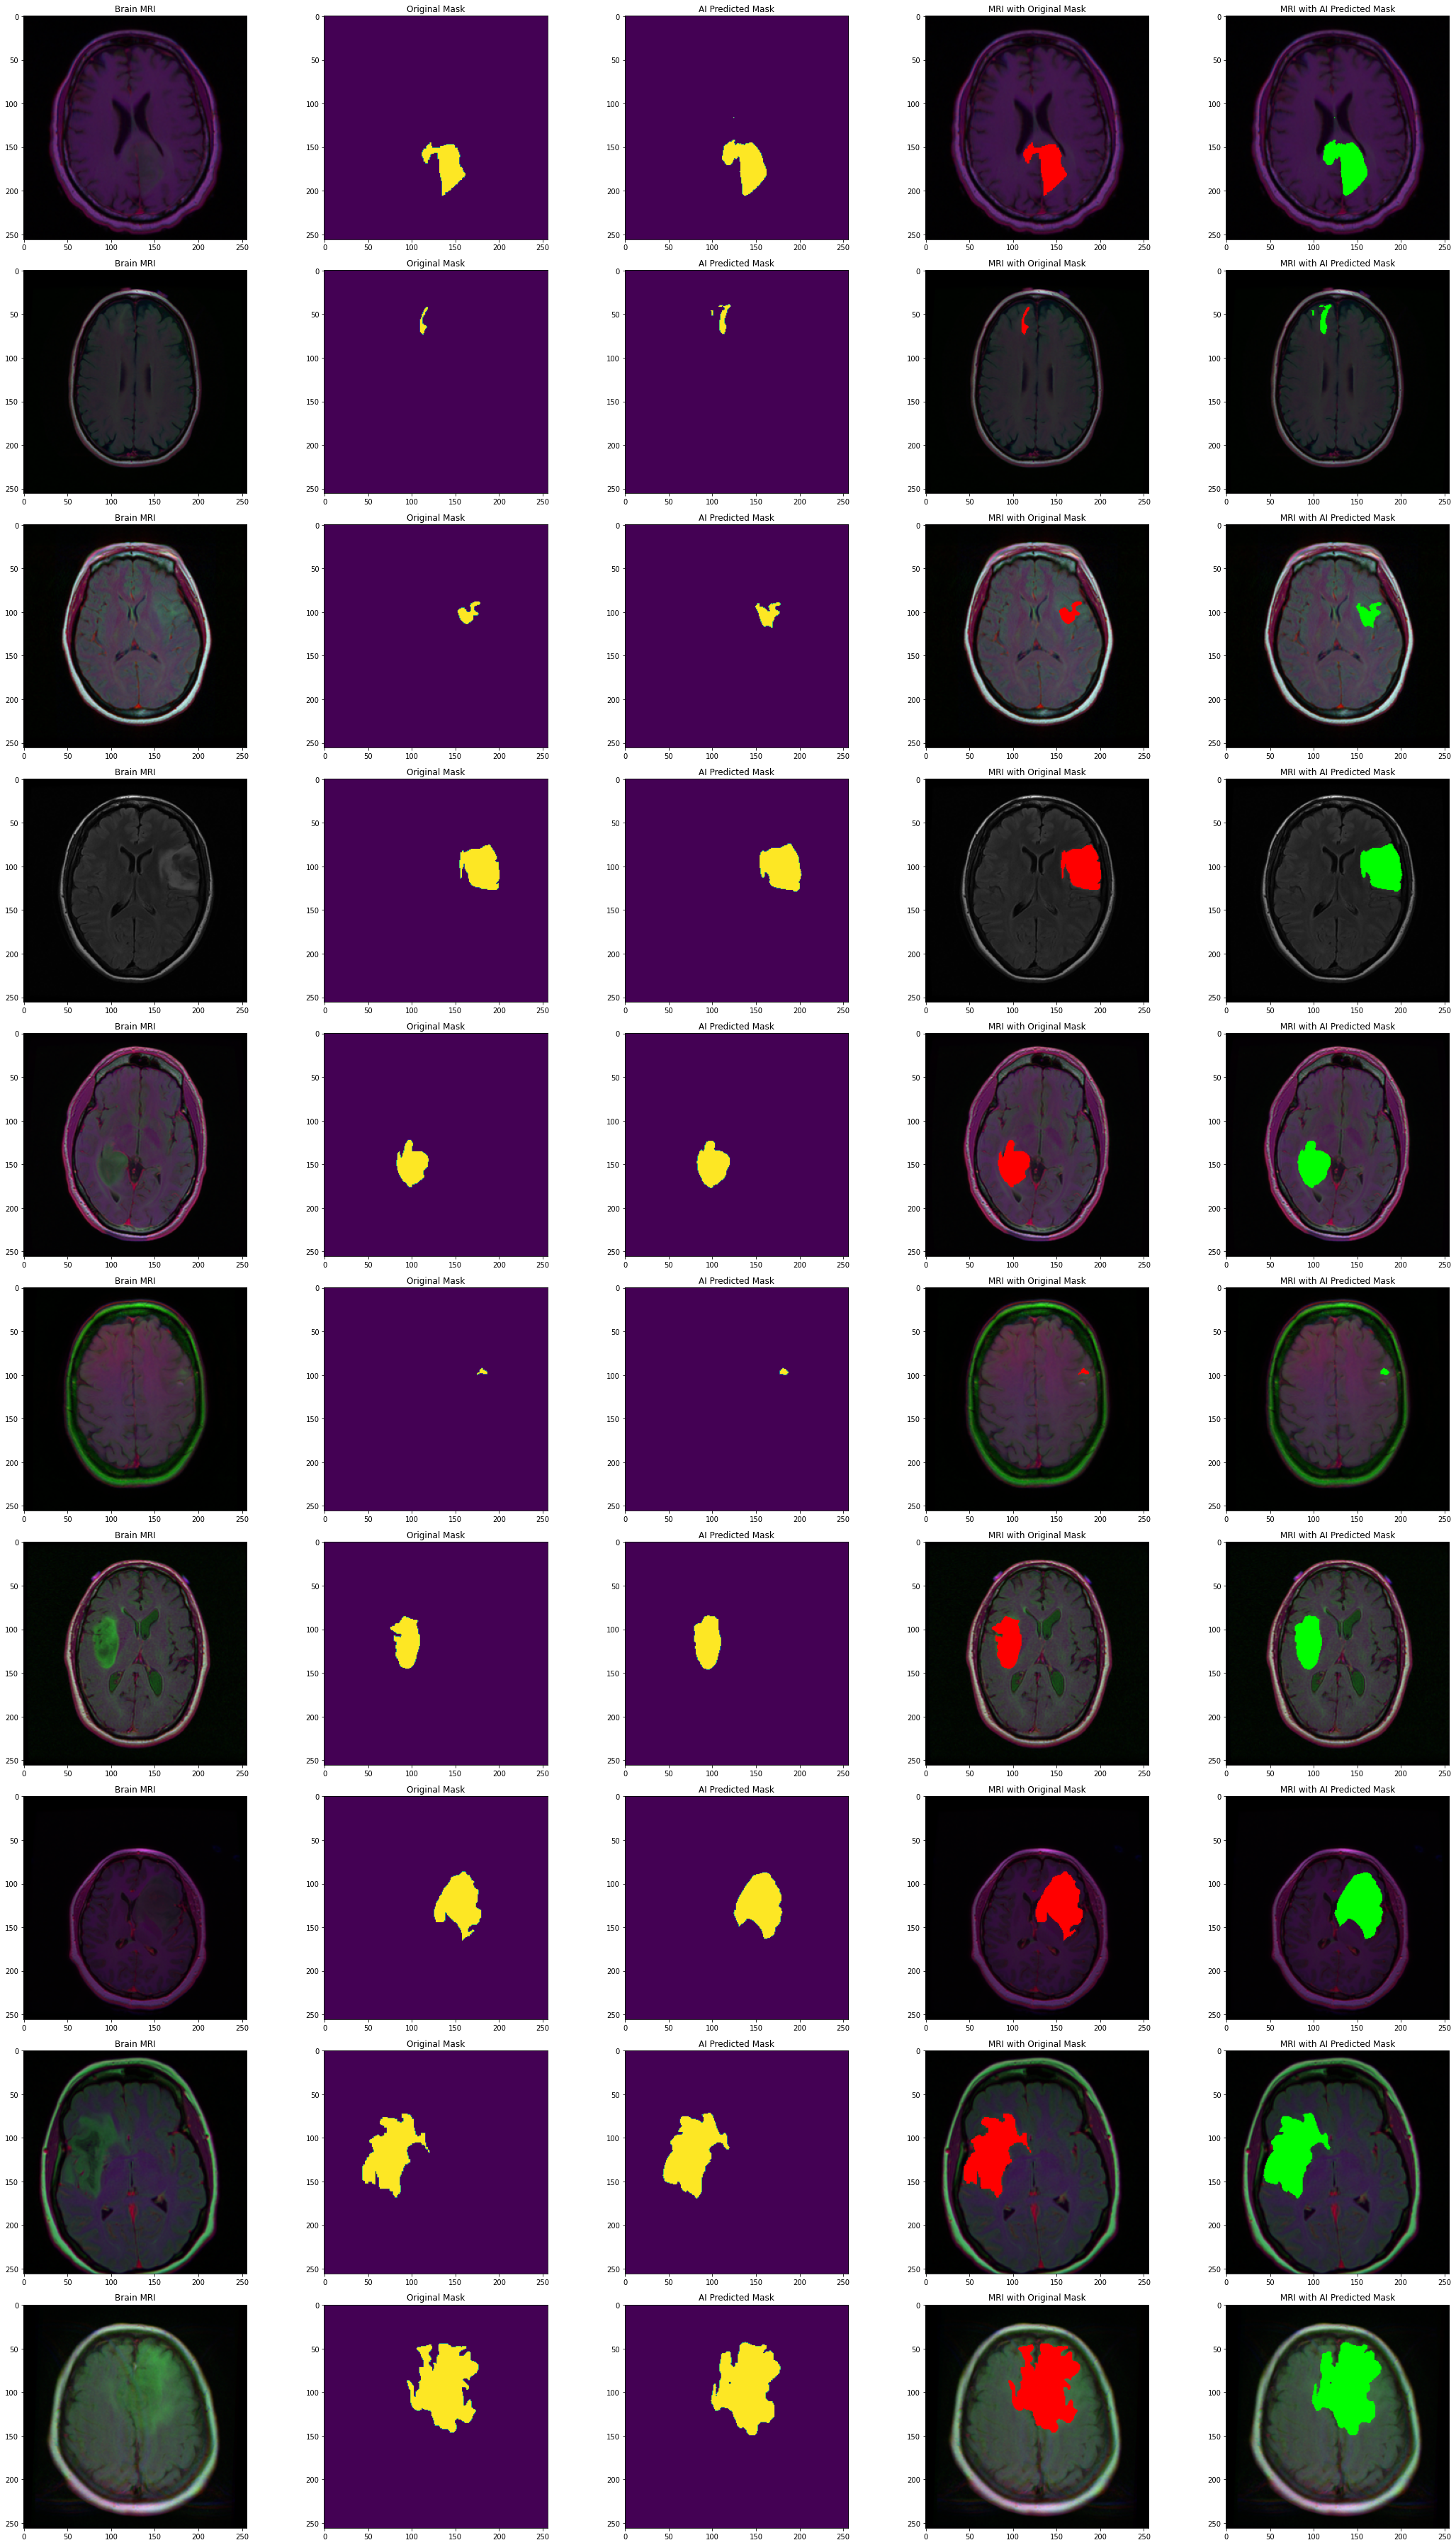

In [ ]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

# THE END